The sklearn `sklearn.datasets` api is useful for downloading datasets from the internet, access bundled datasets within sklearn or create fake datasets for testing purpose.

`fetch_*`: to download dataset  
`load_*`: load toy dataset within sklearn  
`make_*`: generate fake dataset, returned in (X,y) tuple  

In [1]:
import numpy as np

In [2]:
from sklearn.datasets import fetch_openml

In [12]:
mnist = fetch_openml('mnist_784', as_frame=False)

**As we can see, the dataset is returned as a dictionary.**

In [13]:
X, y = mnist.data, mnist.target

In [14]:
X.shape

(70000, 784)

In [15]:
y.shape

(70000,)

## Lets see one of the image

In [16]:
import matplotlib.pyplot as plt

def display_img(img_data=None):
    img_reshape = img_data.reshape(28,28)
    plt.imshow(img_reshape, cmap="binary")
    plt.axis("off")
    

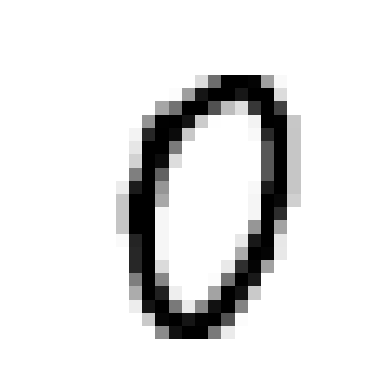

In [17]:
display_img(img_data=X[1000])

In [18]:
y[1000]

'0'

### Train test split

In [19]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a binary classification

Let us try to distinguish between 1 or not 1. 

In [20]:
y_train_1 = (y_train == "2")

In [21]:
y_train_1

array([False, False, False, ..., False, False, False])

In [22]:
y_test_1 = (y_test == "2")

## Using Schocastic Gradient Descent (SGD) classifier 

In [25]:
from sklearn.linear_model import SGDClassifier

In [26]:
sgd_clf = SGDClassifier(random_state=42)

In [27]:
sgd_clf.fit(X_train, y_train_1)

SGDClassifier(random_state=42)

In [29]:
sgd_clf.predict([X_train[100]])

array([False])

In [30]:
y_train[100]

'5'

## Performance Measures

### Measuring accuracy with k fold cross validation

In [31]:
from sklearn.model_selection import cross_val_score

In [32]:
cross_val_score(sgd_clf, X_train, y_train_1, cv=3, scoring="accuracy")

array([0.96645, 0.95895, 0.904  ])

The accuracy looks promising! But, our dataset is imbalanced. The images which are not 1 are aorund 90% and images with 1 is just 10%.

So, if you say that not 1, you will be right 90% of time.


So, when we are dealing with skewed datasets, specially when trying to solve classification problem, accuracy is not generally preffered. 

In [33]:
# Implement Cross-Validation // tomorrow // page: 108

## Confusion Matrices

The general idea of a confusion matrix is to count the number of times instances of class A are classified as class B, for all A/B pairs.

For example, to know the number of times the classifier confused images of 8s with 0s, we will look at row #8, column #0 of the confusion matrix.


We will use `cross_val_predict` function to look into the precition made by our classifier in each fold.

In [34]:
from sklearn.model_selection import cross_val_predict

In [35]:
y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_1, cv=3)

In [36]:
y_train_predict

array([False, False, False, ..., False, False, False])

In [37]:
from sklearn.metrics import confusion_matrix

In [38]:
cm = confusion_matrix(y_train_1, y_train_predict)

In [39]:
cm

array([[51538,  2504],
       [  908,  5050]])

Here, the rows represent classes in our dataset and the column represents predicted class.


The first row considers negative class, i.e non-1:  

52917 were correctly predicted as non-1, these are **true negatives**  
341 were incorrectly  predicted as 1, these are **false positives**  
  
483 were correctly predicted as 1, these are **fasle negatives**  
6259 were incorrectly predicted as 1, there are **true positive**  




In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve

In [44]:
precision_score(y_train_1, y_train_predict)

0.6685199894095843

In [45]:
recall_score(y_train_1, y_train_predict)

0.8475998657267539

## F1 Socre

F1 score is the harmonic mean of precision and recall. As, harmonic mean gives much more weight to low values. F1 score will be high only if both precision and recall are high.

In [46]:
f1_score(y_train_1, y_train_predict)

0.7474837181764358

## The precision-recall trade-off

  
Low recall means the model is missing many actual positive cases (high false negatives).  
High precision means that when the model does predict a positive, it is usually correct (low false positives).  

### How can we define a correct threshold, so that we balance the both.

In [52]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_1, cv=3, method="decision_function")

#decision function scores instead of predicted class label

**The decision function returns raw scores (real-valued numbers) that indicate the distance of the samples from the decision boundary (or hyperplane).**

In [50]:
y_scores

array([-36851.09465219, -31272.70892659, -21491.02754016, ...,
       -30052.05804538, -18789.24492043, -20051.24297549])

In [51]:
y_scores > 0

array([False, False, False, ..., False, False, False])

By default, the SGD Classifier sets the threshold to 0. So, anything above 1 is predicted to be of positive label and anything below is predicted to be of negative label.

Using this scores, we will use `precision_recall_curve()` function to compute precision and recall for all possible threshold.

In [53]:
precisions, recalls, thresholds = precision_recall_curve(y_train_1, y_scores)

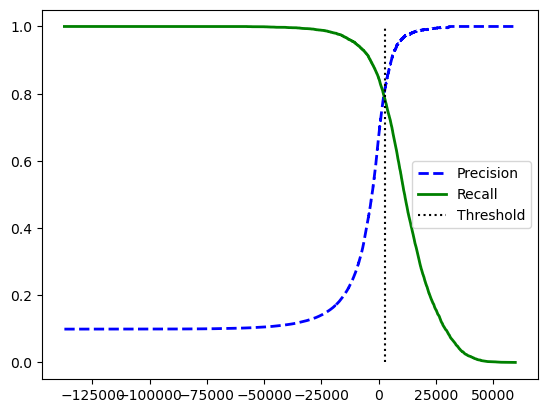

In [54]:
plt.plot(thresholds, precisions[:-1], 'b--', label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g-', label="Recall", linewidth=2)
plt.vlines(3000, 0, 1.0, "k", "dotted", label="Threshold" )

plt.legend()

## Suppose we want our classifier to have 97% precision

1. Find a threshold that gives 97% precision. 

In [55]:
precisions[0]

0.0993

In [56]:
recalls[0]

1.0

In [57]:
thresholds[0]

-137268.8066307551

In [58]:
thresholds[np.argmax(precisions > 0.97)]

11214.202634093046

### threshold of `4976.125167722477` will give us precision greater than 97%

In [82]:
y_pred_97 = y_scores > thresholds[np.argmax(precisions > 0.97)]

In [84]:
precision_score(y_train_1, y_pred_97)

0.9701415257162582

In [85]:
recall_score(y_train_1, y_pred_97)

0.8337288638386235

We have our precision 97%, and as you can see our recall has decreased to 83%

## The ROC Curve

The ROC Curve plots the true positive rates(another recall) againts the false positive Rate(FPR). The FPR is also called fallout.

The **FPR(False Positive Rate)**, is the ratio of negative instances that are incorrectly classified as positives.

The FPR is equal to, `1 - True Negatives Rate(TNR)`